In [1]:
%pip install timm mplcyberpunk ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import os, json, random, math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy

try:
    from tqdm.auto import tqdm
except Exception:
    from tqdm import tqdm  

import timm
import mplcyberpunk
plt.style.use("cyberpunk")

In [3]:
print("torch:", torch.__version__)
print("timm :", timm.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

torch: 2.5.1+cu121
timm : 1.0.19
device: cuda
GPU: NVIDIA GeForce GTX 1650 Ti


In [5]:

REPO_ROOT = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing")

DATA_DIR  = REPO_ROOT / "data" / "processed" / "classification" / "leukemia_classification"

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "validation"
TEST_DIR  = DATA_DIR / "test"

assert TRAIN_DIR.exists(), f"Missing: {TRAIN_DIR}"
assert VAL_DIR.exists(), f"Missing: {VAL_DIR}"
assert TEST_DIR.exists(), f"Missing: {TEST_DIR}"

In [6]:
from torchvision import transforms, datasets
from torch.utils.data import ConcatDataset, DataLoader

In [7]:
# Normalization for ImageNet-pretrained ViT
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [8]:
train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [12]:
from torchvision import datasets

# folds live under train/
folds = ["fold_0", "fold_1", "fold_2"]

train_datasets = []
for f in folds:
    fold_path = TRAIN_DIR / f
    train_datasets.append(datasets.ImageFolder(fold_path, transform=train_tfms))

val_ds  = datasets.ImageFolder(VAL_DIR,  transform=val_tfms)
test_ds = datasets.ImageFolder(TEST_DIR, transform=val_tfms)

from torch.utils.data import ConcatDataset
train_ds = ConcatDataset(train_datasets)

print("Train size:", len(train_ds))
print("Val size:  ", len(val_ds))
print("Test size: ", len(test_ds))
print("Classes:", val_ds.classes)


Train size: 8885
Val size:   1776
Test size:  1867
Classes: ['all', 'hem']


In [14]:
from torch.utils.data import DataLoader

batch_size  = 32
num_workers = 0
pin         = torch.cuda.is_available()

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=pin
)

val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin
)

test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin
)

print("Steps per epoch:", len(train_loader), len(val_loader), len(test_loader))


xb, yb = next(iter(train_loader))
print("First batch:", xb.shape, yb.shape)

Steps per epoch: 278 56 59
First batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [15]:
vit_name = "vit_tiny_patch16_224"

# create model
model = timm.create_model(vit_name, pretrained=True, num_classes=len(val_ds.classes))
model = model.to(device)

print("Model:", vit_name)

Model: vit_tiny_patch16_224


*Define Loss, Optimizer, Scheduler, and Training Setup*

In this step, we configure the core training components for our Vision Transformer (ViT) model:

- Loss Function:
We use CrossEntropyLoss, which is the standard choice for multi-class classification problems.

- Optimizer:
We use AdamW, a variant of Adam that includes weight decay, which works particularly well for transformer-based models. The learning rate is scaled relative to the batch size.

- Learning Rate Scheduler:
We adopt a CosineAnnealingLR scheduler. This gradually reduces the learning rate following a cosine curve, which helps the model converge smoothly and avoid sharp drops in performance.

- Mixed Precision Training (AMP):
To speed up training and reduce GPU memory usage, we use torch.cuda.amp with a gradient scaler. This allows calculations in half precision without sacrificing accuracy.

This setup ensures that our ViT model trains efficiently and generalizes better on the validation and test datasets.

In [16]:
import torch.nn as nn
import torch.optim as optim

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
base_lr = 3e-4 * (batch_size / 32)
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.05)

# Scheduler
epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

print("Training for", epochs, "epochs with lr:", base_lr)


Training for 20 epochs with lr: 0.0003


In [17]:
from torch.cuda.amp import autocast, GradScaler
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from tqdm.auto import tqdm

In [18]:
scaler = GradScaler(enabled=torch.cuda.is_available())

def run_epoch(loader, train=True):
    model.train(train)
    loss_sum = 0.0
    logits_all, targets_all = [], []
    
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        logits_all.append(logits.detach().cpu())
        targets_all.append(y.detach().cpu())

    loss_epoch = loss_sum / len(loader.dataset)
    logits_all = torch.cat(logits_all)
    targets_all = torch.cat(targets_all)

    auroc = MulticlassAUROC(num_classes=len(val_ds.classes), average="macro")(logits_all.softmax(1), targets_all).item()
    acc   = MulticlassAccuracy(num_classes=len(val_ds.classes), average="macro")(logits_all.argmax(1), targets_all).item()

    return loss_epoch, acc, auroc


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15148\1646186778.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [19]:
from pathlib import Path
import json

In [20]:
def fit(epochs=20, ckpt_name="cls_leukemia_vit_tiny.pt"):
    CKPT_DIR = REPO_ROOT / "checkpoints" / "classification"
    MET_DIR  = REPO_ROOT / "results" / "metrics"
    CKPT_DIR.mkdir(parents=True, exist_ok=True)
    MET_DIR.mkdir(parents=True, exist_ok=True)

    best = -1e9
    hist = []
    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_auc = run_epoch(train_loader, True)
        va_loss, va_acc, va_auc = run_epoch(val_loader, False)
        scheduler.step()

        hist.append({
            "epoch": ep,
            "train_loss": tr_loss, "train_acc": tr_acc, "train_auroc": tr_auc,
            "val_loss": va_loss, "val_acc": va_acc, "val_auroc": va_auc,
            "lr": scheduler.get_last_lr()[0]
        })

        print(f"[{ep:03d}] train: loss {tr_loss:.4f} acc {tr_acc:.3f} auc {tr_auc:.3f} | "
              f"val: loss {va_loss:.4f} acc {va_acc:.3f} auc {va_auc:.3f}")

        if va_auc > best:
            best = va_auc
            torch.save({
                "state_dict": model.state_dict(),
                "class_names": val_ds.classes,
                "num_classes": len(val_ds.classes),
                "model_name": vit_name
            }, CKPT_DIR / ckpt_name)

    with open(MET_DIR / "leukemia_vit_history.json", "w") as f:
        json.dump(hist, f, indent=2)

    print("Best val AUROC:", best)
    return hist

In [21]:
history = fit(epochs=epochs, ckpt_name=f"cls_leukemia_{vit_name}.pt")


  0%|          | 0/278 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15148\1646186778.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


  0%|          | 0/56 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15148\1646186778.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


[001] train: loss 0.5342 acc 0.677 auc 0.766 | val: loss 0.6549 acc 0.542 auc 0.750


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[002] train: loss 0.4498 acc 0.744 auc 0.830 | val: loss 0.5029 acc 0.686 auc 0.784


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[003] train: loss 0.3981 acc 0.785 auc 0.869 | val: loss 0.5168 acc 0.667 auc 0.789


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[004] train: loss 0.3721 acc 0.802 auc 0.884 | val: loss 0.4904 acc 0.663 auc 0.816


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[005] train: loss 0.3497 acc 0.816 auc 0.898 | val: loss 0.4404 acc 0.731 auc 0.820


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[006] train: loss 0.3287 acc 0.832 auc 0.908 | val: loss 0.5300 acc 0.677 auc 0.833


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[007] train: loss 0.3184 acc 0.834 auc 0.914 | val: loss 0.4007 acc 0.767 auc 0.850


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[008] train: loss 0.2876 acc 0.850 auc 0.930 | val: loss 0.4394 acc 0.762 auc 0.834


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[009] train: loss 0.2732 acc 0.860 auc 0.936 | val: loss 0.4194 acc 0.749 auc 0.857


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[010] train: loss 0.2517 acc 0.873 auc 0.945 | val: loss 0.4136 acc 0.719 auc 0.897


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[011] train: loss 0.2407 acc 0.880 auc 0.951 | val: loss 0.4660 acc 0.715 auc 0.902


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[012] train: loss 0.2245 acc 0.890 auc 0.956 | val: loss 0.3843 acc 0.751 auc 0.904


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[013] train: loss 0.2074 acc 0.895 auc 0.964 | val: loss 0.3692 acc 0.767 auc 0.930


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[014] train: loss 0.1877 acc 0.909 auc 0.970 | val: loss 0.3355 acc 0.800 auc 0.920


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[015] train: loss 0.1719 acc 0.916 auc 0.974 | val: loss 0.3081 acc 0.827 auc 0.927


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[016] train: loss 0.1586 acc 0.921 auc 0.980 | val: loss 0.3771 acc 0.776 auc 0.935


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[017] train: loss 0.1470 acc 0.927 auc 0.982 | val: loss 0.2668 acc 0.843 auc 0.951


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[018] train: loss 0.1309 acc 0.938 auc 0.986 | val: loss 0.2769 acc 0.850 auc 0.943


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[019] train: loss 0.1270 acc 0.936 auc 0.987 | val: loss 0.2854 acc 0.842 auc 0.950


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[020] train: loss 0.1218 acc 0.940 auc 0.988 | val: loss 0.2797 acc 0.849 auc 0.950
Best val AUROC: 0.9507986307144165


In [22]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt, matplotlib.patheffects as pe
import mplcyberpunk
plt.style.use("cyberpunk")

In [23]:
model.eval()
logits_list, targets_list = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits_list.append(model(x).cpu())
        targets_list.append(torch.as_tensor(y))

logits   = torch.cat(logits_list)           
probs_t  = torch.softmax(logits, dim=1)     
targets  = torch.cat(targets_list).long()   
preds_t  = probs_t.argmax(dim=1)  

In [24]:
auroc = MulticlassAUROC(num_classes=len(val_ds.classes), average="macro")(probs_t, targets).item()
acc   = MulticlassAccuracy(num_classes=len(val_ds.classes), average="macro")(preds_t, targets).item()
preds = preds_t.numpy()
targets_np = targets.numpy()

prec, rec, f1, sup = precision_recall_fscore_support(
    targets_np, preds, labels=range(len(val_ds.classes)), zero_division=0
)

print(f"Test Accuracy (macro): {acc:.4f}")
print(f"Test Macro AUROC    : {auroc:.4f}")

Test Accuracy (macro): 0.6270
Test Macro AUROC    : 0.7869


In [25]:
per_class_df = pd.DataFrame(
    {"precision": prec, "recall": rec, "f1": f1, "support": sup},
    index=val_ds.classes
)
display(per_class_df)

,precision,recall,f1,support
all,0.719603,0.951600,0.819498,1219
hem,0.768627,0.302469,0.434109,648


In [26]:
cm = confusion_matrix(targets_np, preds)

def plot_confusion_matrix_cyberpunk(cm, class_names, title, save_path=None, normalize=False):
    cm_disp = cm.astype(float)
    if normalize:
        row_sums = cm_disp.sum(axis=1, keepdims=True).clip(min=1)
        cm_disp = cm_disp / row_sums

    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(cm_disp, cmap="magma")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(class_names)), labels=class_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm_disp[i, j]:.2f}" if normalize else f"{cm[i, j]}"
            ax.text(j, i, txt, ha="center", va="center", color="white", fontsize=10,
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    mplcyberpunk.make_lines_glow(ax=ax)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
        print("Saved →", save_path)
    plt.show()

FIG_DIR = REPO_ROOT / "results" / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

Saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\vit_confusion_matrix_counts.png


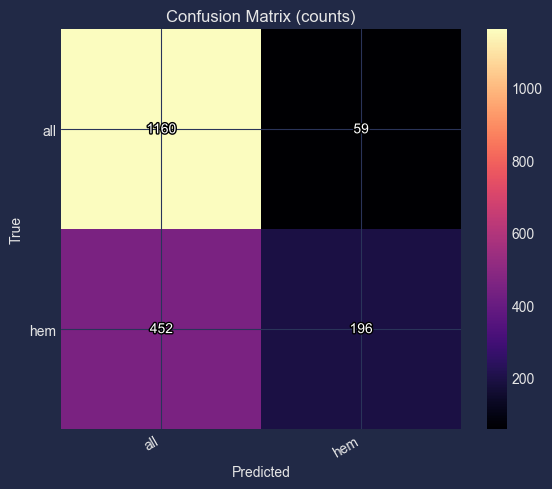

In [27]:
plot_confusion_matrix_cyberpunk(
    cm, val_ds.classes,
    title="Confusion Matrix (counts)",
    save_path=FIG_DIR / "vit_confusion_matrix_counts.png",
    normalize=False
)

Saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\vit_confusion_matrix_norm.png


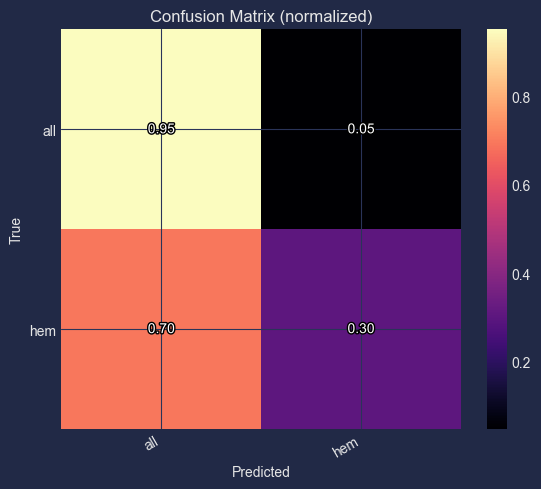

In [28]:
plot_confusion_matrix_cyberpunk(
    cm, val_ds.classes,
    title="Confusion Matrix (normalized)",
    save_path=FIG_DIR / "vit_confusion_matrix_norm.png",
    normalize=True
)

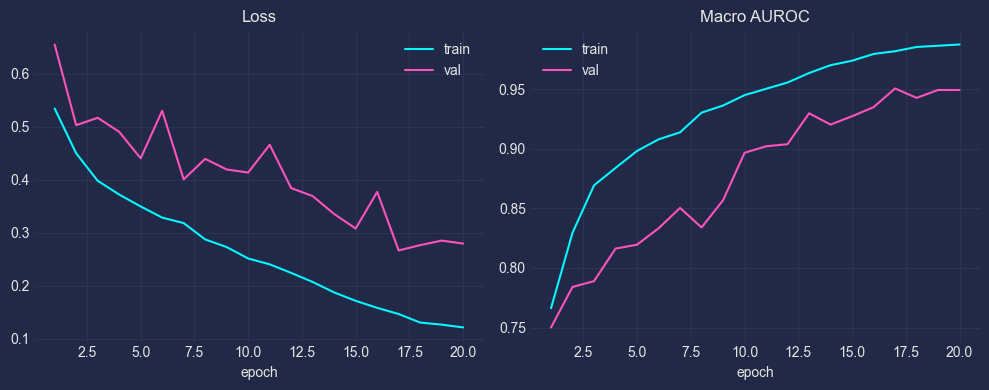

In [29]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

hist_path = REPO_ROOT / "results" / "metrics" / "leukemia_vit_history.json"
hist = json.loads(Path(hist_path).read_text())

# Extract values
epochs  = [h["epoch"] for h in hist]
tr_loss = [h["train_loss"] for h in hist]; va_loss = [h["val_loss"] for h in hist]
tr_auc  = [h["train_auroc"] for h in hist]; va_auc  = [h["val_auroc"] for h in hist]

# Plot Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, tr_loss, label="train"); plt.plot(epochs, va_loss, label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.legend()

# Plot AUROC
plt.subplot(1,2,2)
plt.plot(epochs, tr_auc, label="train"); plt.plot(epochs, va_auc, label="val")
plt.title("Macro AUROC"); plt.xlabel("epoch"); plt.legend()

plt.tight_layout(); plt.show()


In [31]:
# === Export ViT model to ONNX & TorchScript ===
from pathlib import Path
import torch

onnx_out = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\onnx\leukemia_vit_tiny.onnx")
ts_out   = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\torchscript\leukemia_vit_tiny.pt")

onnx_out.parent.mkdir(parents=True, exist_ok=True)
ts_out.parent.mkdir(parents=True, exist_ok=True)

dummy = torch.randn(1, 3, 224, 224, device=device)
model.eval()

# Export to ONNX
torch.onnx.export(
    model, dummy, onnx_out.as_posix(),
    input_names=["input"], output_names=["logits"],
    opset_version=17, do_constant_folding=True,
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}}
)
print("ONNX saved →", onnx_out)

# Export to TorchScript
traced = torch.jit.trace(model, dummy)
traced.save(ts_out.as_posix())
print("TorchScript saved →", ts_out)


c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\.venv\Lib\site-packages\torch\__init__.py:2040: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


ONNX saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\onnx\leukemia_vit_tiny.onnx
TorchScript saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\torchscript\leukemia_vit_tiny.pt
